In [1]:
import os
import numpy as np
from scipy.fftpack import fft
from scipy import signal
import gc
from scipy.io import wavfile

from sklearn.metrics import recall_score, accuracy_score, f1_score, confusion_matrix, classification_report

import time

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
import torch.utils.data as utils
import torch.nn.functional as F

import random

In [2]:
random.seed(97)
batch_size = 16
L = 16000
legal_labels = 'yes no up down left right on off stop go silence unknown'.split()
LABELS_NUM = 12
N_EPOCHS = 12
TRAIN_MAX_SIZE = 500
train_data_path = os.path.join('train', 'audio') # the only setting: where your data should be

TRAIN_FILES_NUM = 50000 
TEST_FILES_NUM = 10000 

In [3]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, padding=2),
            nn.BatchNorm2d(1),
            nn.ReLU(),
            nn.Dropout2d(0.15),
            nn.MaxPool2d(2)
        )
        self.fc1 = nn.Linear(1 * 50 * 41, 64)
        self.dense1_bn = nn.BatchNorm1d(64)
        self.fc2 = nn.Linear(64, LABELS_NUM)

    def forward(self, x):
        out = self.layer1(x)
        out = out.view(out.size(0), -1)
        out = F.relu(self.dense1_bn(self.fc1(out)))
        out = F.log_softmax(self.fc2(out))
        return out

In [4]:
cnn = CNN()
# cnn.load_state_dict(torch.load('MODEL_SAVE'))
criterion = nn.MultiLabelSoftMarginLoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001)

In [5]:
def custom_fft(y, fs):
    T = 1.0 / fs
    N = y.shape[0]
    yf = fft(y)
    xf = np.linspace(0.0, 1.0 / (2.0 * T), N // 2)
    vals = 2.0 / N * np.abs(yf[0:N // 2])
    return xf, vals


def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                            fs=sample_rate,
                                            window='hann',
                                            nperseg=nperseg,
                                            noverlap=noverlap,
                                            detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)


def list_wavs_fname(dirpath, ext='wav'):
    fnames = []
    labels = []
    for path, subdirs, files in os.walk(dirpath):
        for name in files:
            if name.endswith(ext):
                fnames.append(name)
                labels.append(path.split('\\')[-1])

    return labels, fnames


def pad_audio(samples):
    if len(samples) >= L:
        return samples
    else:
        return np.pad(samples, pad_width=(L - len(samples), 0), mode='constant', constant_values=(0, 0))


def chop_audio(samples, L=16000, num=20):
    for i in range(num):
        beg = np.random.randint(0, len(samples) - L)
        yield samples[beg: beg + L]


def label_transform(y):
    nlabels = []
    for label in y:
        res = np.zeros(LABELS_NUM)
        if label == '_background_noise_':
            res[legal_labels.index('silence')] = 1
        elif label not in legal_labels:
            res[legal_labels.index('unknown')] = 1
        else:
            res[legal_labels.index(label)] = 1
        nlabels.append(res)
    return nlabels

In [6]:
new_sample_rate = 8000  # 16000
k = 0.8

labels, fnames = list_wavs_fname(train_data_path)

shuffled = list(zip(labels, fnames))
random.shuffle(shuffled)

train_len = int(len(labels) * k)
train_files_list = shuffled[:train_len]
valid_files_list = shuffled[train_len:]

In [7]:
def generate_data(files_list, max_num, epochs=N_EPOCHS):
    batch_num = 0
    for epoch in range(epochs):
        y_train = []
        x_train = []
        ind = 0
        for label, fname in files_list:
            ind += 1
            if ind > max_num:
                break
            sample_rate, samples = wavfile.read(os.path.join(train_data_path, label, fname))
            samples = pad_audio(samples)
            if len(samples) > 16000:
                n_samples = chop_audio(samples)
            else:
                n_samples = [samples]
            for samples in n_samples:
                resampled = signal.resample(samples, int(new_sample_rate / sample_rate * samples.shape[0]))
                _, _, specgram = log_specgram(resampled, sample_rate=new_sample_rate)
                x_train.append(specgram)
                y_train.append(label)
            if len(x_train) == TRAIN_MAX_SIZE:
                batch_num += 1
                x_train = np.array(x_train)
                x_train = x_train.reshape(tuple([list(x_train.shape)[0]] + [1] + list(x_train.shape)[1:]))
                y_train = label_transform(y_train)
                y_train = np.array(y_train)
                tensor_X = torch.stack([torch.FloatTensor(x) for x in x_train])
                tensor_y = torch.stack([torch.FloatTensor(y) for y in y_train])
                train_dataset = utils.TensorDataset(tensor_X, tensor_y)
                train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
                yield train_loader, batch_num
                y_train = []
                x_train = []
                gc.collect()

In [8]:
train_generator = generate_data(train_files_list, max_num=TRAIN_FILES_NUM)
acc_list = []
recall_list = []
f1_list = []
try:
    while True:
        train_loader, batch_num = next(train_generator)
        cnn.train()
        loss_list = []
        for i, (images, labels) in enumerate(train_loader):
            images = Variable(images)
            labels = Variable(labels)
            optimizer.zero_grad()
            outputs = cnn(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            loss_list.append(loss.data[0])

        if batch_num % (TRAIN_FILES_NUM // TRAIN_MAX_SIZE) == 0:
            cnn.eval()
            valid_generator = generate_data(valid_files_list, epochs=1, max_num=TEST_FILES_NUM)
            real_labels = []
            pred_labels = []
            while True:
                try:
                    valid_loader, _ = next(valid_generator)

                    for i, (images, labels) in enumerate(valid_loader):
                        images = Variable(images)
                        outputs = cnn(images)
                        _, predicted = torch.max(outputs.data, 1)
                        pred_labels += list(predicted)
                        for label in labels:
                            real_labels.append(list(label).index(1))
                except:
                    break

            print('Test on %d valid files:' % len(real_labels))

            acc_list.append(accuracy_score(real_labels, pred_labels))
            recall_list.append(np.mean(recall_score(real_labels, pred_labels, average=None)))
            f1_list.append(np.mean(f1_score(real_labels, pred_labels, average=None)))
            print('Validation accuracy', acc_list[-1])
            print('Validation recall', recall_list[-1])
            print('Validation F1', f1_list[-1])
            print('Confusion matrix\n', confusion_matrix(real_labels, pred_labels))
            print()

except:
    print('Training end')
    torch.save(cnn.state_dict(), 'MODEL_SAVE')

C:\Users\IMBD\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\IMBD\Anaconda3\lib\site-packages\scipy\io\wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


Test on 10000 valid files:
Validation accuracy 0.649
Validation recall 0.16323824809068202
Validation F1 0.16937276520019742
Confusion matrix
 [[  28    0    1    0    1    1    0    1    0    0  340]
 [   0    1    0    0    0    0    0    3    1    0  371]
 [   0    0   18    0    0    0    0   38   13    0  319]
 [   0    0    0    0    0    0    1    3    0    0  361]
 [   1    0    0    0    8    0    0    7    0    0  339]
 [   0    0    0    0    0    0    0    1    0    0  366]
 [   0    0    3    0    0    0   32   32    3    0  288]
 [   0    0    6    0    0    0    2  163    7    0  177]
 [   0    0   11    0    0    0    0   25   45    0  297]
 [   0    0    0    0    0    0    0    5    1    1  348]
 [   1    0    7    0    2    0   18   93   16    0 6194]]



C:\Users\IMBD\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Test on 10000 valid files:
Validation accuracy 0.6851
Validation recall 0.2872040455531803
Validation F1 0.33287734201503766
Confusion matrix
 [[ 137    2    1    0   17    1    0    2    3    0  209]
 [   1   35    0    1    1    0    0    3    1    3  331]
 [   1    0   55    0    2    0    2   52   40    1  235]
 [   0    4    0   19    0    0    3    5    6    0  328]
 [  11    1    5    0  110    1    0   13    0    0  214]
 [   1    0    0    0   14   44    0    3    0    0  305]
 [   1    1    4    0    0    0   58   55    4    0  235]
 [   0    0   14    0    3    0    3  195    8    0  132]
 [   0    0   29    0    2    0    0   22  133    0  192]
 [   1   14    1    0    2    0    0    8    3   20  306]
 [  35   14   31    4   22    1   17  116   45    1 6045]]

Test on 10000 valid files:
Validation accuracy 0.7069
Validation recall 0.3271854327447618
Validation F1 0.39133458363411927
Confusion matrix
 [[ 161    2    1    0    5    1    1    2    2    0  197]
 [   1   41    3

C:\Users\IMBD\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\IMBD\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Test on 10000 valid files:
Validation accuracy 0.734
Validation recall 0.4548233492663228
Validation F1 0.49094535363280983
Confusion matrix
 [[ 205    3    2    2   21    1    0    3    2    1    2  130]
 [   6  110    9   12    3    0    1    0    3   60    0  172]
 [   0    1  160    1    7    0    3   27   44    4    2  139]
 [   0   10    6  108    2    0   12    2   10   13    0  202]
 [  15    3    8    1  194   14    0   10    2    1    1  106]
 [   2    2    4    1   18  163    1    2    0    0    0  174]
 [   0    0    5    2    1    1  173   24    4    0    1  147]
 [   0    0   22    0   11    0    7  218    9    1    0   87]
 [   0    0   50    0    3    0    1   14  205    5    1   99]
 [   1   20    9    9    0    0    1    1    6  135    0  173]
 [   0    0    0    0    0    0    0    0    0    0    0    0]
 [  49   31   72   42   61   65  143   89   54   55    1 5669]]

Test on 10000 valid files:
Validation accuracy 0.747
Validation recall 0.44486689414999847
Validatio

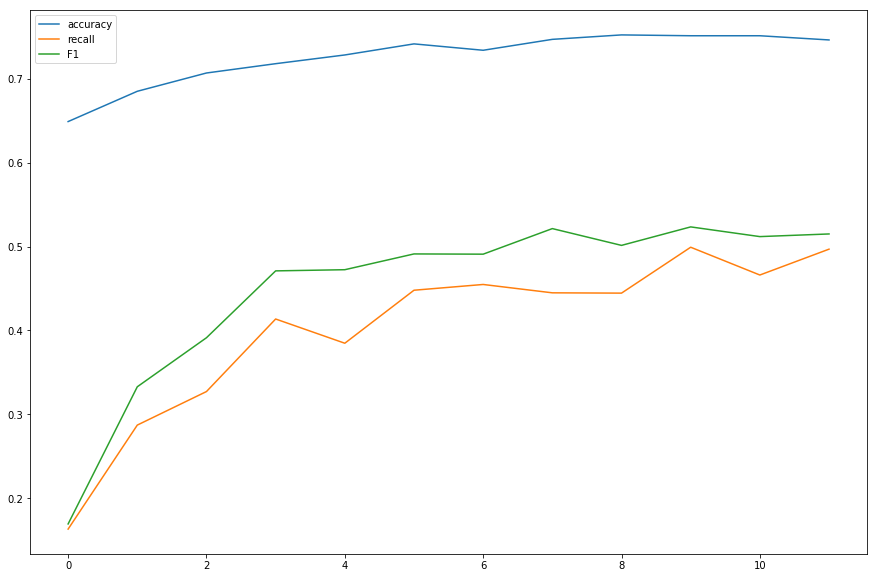

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 15, 10
x = np.arange(len(acc_list))
plt.plot(x, acc_list)
plt.plot(x, recall_list)
plt.plot(x, f1_list)              
plt.legend(['accuracy', 'recall', 'F1'])
plt.show()